In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
sns.set_style("darkgrid")

## Preliminary Stuff

In [32]:
data = pd.read_csv('clean_data.csv')
# First we need to create the outcome variable
data['over_under']=(train['comments']>train['comments'].median()).astype(int)
print(data.shape)
data.head()

(2959, 10)


,title,subreddit,comments,minutes,which_sub,AskReddit,big4,others,length,over_under
0,my shower mat fits snug up against the tub,Perfectfit,108,480,others,0,0,1,42,1
1,mrw when i'm at the african american history m...,reactiongifs,78,180,others,0,0,1,199,1
2,v.3.0.0 downtime update!,FortNiteBR,362,480,others,0,0,1,24,1
3,welcome to season 3: battle pass breakdown,FortNiteBR,1005,540,others,0,0,1,42,1
4,a css keylogger,programming,203,900,others,0,0,1,15,1


In [34]:
# Split the training data into a further train/test split (remember, we set aside 30% earlier for final testing)
X = train.drop(['comments', 'over_under'], axis=1)
y = train['over_under']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
X_train.shape

(2071, 8)

## Count Vectorizer on `Title`

In [4]:
# Initialize a standard CountVectorizer and fit the training data.
cvec = CountVectorizer(stop_words='english', max_features=1000)
cvec.fit(X_train['title']);
cvecdata = cvec.transform(X_train['title'])
cvec_title  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

In [5]:
# What is the shape of that dataframe?
cvec_title.shape # It has about 2,000 posts and about 6,000 words

(2071, 1000)

In [6]:
# Check out that matrix
cvec_title.head(3)

,00,000,10,100,12,14,15,18,19,1983,...,wow,wrong,xbox,yard,yeah,year,years,yesterday,young,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# What's the distribution of common words?
common=cvec_title.sum()
print(common.describe()) 
# 75% of the words appear less than 2 times.

count    1000.000000
mean        5.890000
std         5.517821
min         3.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        61.000000
dtype: float64


### Check out the most commonly used words (this is purely exploratory & doesn't affect my model)

In [8]:
common=cvec_title.sum()

In [9]:
# Because we set max_feature=1000, these are the 1000 most commonly used words. About half get 4+ appearances.
print(common.describe())

count    1000.000000
mean        5.890000
std         5.517821
min         3.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        61.000000
dtype: float64


In [10]:
# List the 15 most commonly used words.
common.sort_values(ascending=False).head(15) 

just      61
time      50
like      49
new       47
people    46
don       37
got       36
day       36
man       35
today     35
til       32
black     29
oc        27
old       26
game      26
dtype: int64

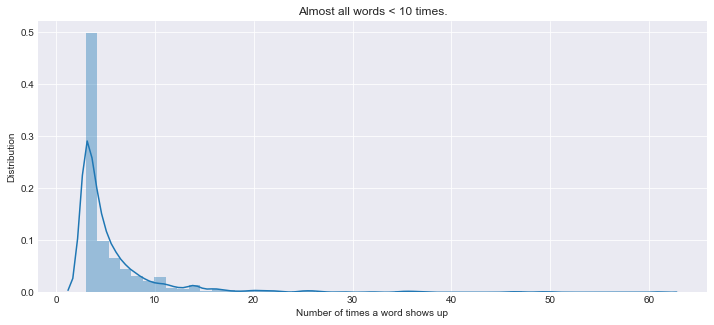

In [11]:
#  Here's the distribution of the common words (>2 times)
fig = plt.figure(figsize=(12,5))
ax=sns.distplot(common[common>2]);
ax.set(ylabel='Distribution', xlabel='Number of times a word shows up', title='Almost all words < 10 times.');

## Combine the vectorized `title` with my other feature columns

In [12]:
print(X_train.shape)
X_train.head(3)

(2071, 8)


,title,subreddit,minutes,which_sub,AskReddit,big4,others,length
283,flag of wakanda (from 'black panther'),vexillology,300,others,0,0,1,38
1860,"abandoned pine plantation • laurel hill, austr...",EarthPorn,360,others,0,0,1,67
2056,just... why? i had to step over this multiple ...,OSHA,1080,others,0,0,1,52


In [21]:
# Drop the variables I don't need anymore.
X_train_short=X_train.drop(['title', 'subreddit', 'which_sub', 'others'], axis=1)

In [37]:
# Confirm that the two df's I'm about to merge have the same number of rows
print(X_train_short.shape)
print(cvec_title.shape)

(2071, 4)
(2071, 1000)


In [39]:
# When I merge, I'm losing a lot of rows. But when I concat, I gain them. Why is that?
X_train_cvec=pd.merge(X_train_short, cvec_title, right_index=True, left_index=True)
X_train_cvec2=pd.concat([X_train_short, cvec_title], axis=1)
print(X_train_cvec.shape) # There are no NaN's.
print(X_train_cvec2.shape) # I'm also getting a lot of NaN's here.

(1452, 1004)
(2690, 1004)


## Train a KNN regression  on the vectorized `title` data

In [40]:
X_train.head()

,title,subreddit,minutes,which_sub,AskReddit,big4,others,length
1860,"abandoned pine plantation • laurel hill, austr...",EarthPorn,360,others,0,0,1,67
1556,"the briggs-rauscher reaction, one of the few k...",chemicalreactiongifs,900,others,0,0,1,81
1790,"til of anders haugen, the only american to eve...",todayilearned,720,big4,0,1,0,295
2614,smoobyade,smoobypost,420,others,0,0,1,9
143,local restaurant hires deaf servers and educat...,rva,300,others,0,0,1,81


In [ ]:
#train the model
neighs = KNeighborsClassifier()
knn_model = neighs.fit(cvec_title, y_train)
# One thing I don't get... we aren't using any of the other features we engineered (length, time, subreddit)

In [ ]:
# Now I want to use test data. I'll need to transform my test data the same way I transformed my train data
cvec = CountVectorizer(stop_words='english') # kill this
vectorizers_test = cvec.transform(X_test['title']) # dont fit
#transforming but not fitting my test data.
df_test = pd.DataFrame(vectorizers_test.todense(),
             columns=cvec.get_feature_names())
#putting it all into a dataframe to make it easier to understand

Ultimately, I chose not to use the updated list of stopwords.

In [ ]:
# I expected these three dataframes to have the same shape, but they do not.
print(X_test.shape)
print(y_test.shape)
print(df_test.shape)

In [ ]:
#knn_model.score(df_test, y_test)

## Train a logistic regression on the vectorized data

In [ ]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(X_train['title'])
X_train = pd.DataFrame(cvec.transform(X_train['title']).todense())
X_test = pd.DataFrame(cvec.transform(X_test['title']).todense())

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)